## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras
import itertools
# Enable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [40]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""

gamma = 2.
alpha = 4.
epsilon = 1e-8

def focal_loss_fixed(y_true, y_pred):

    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def cross_entropy_fixed(y_true, y_pred):

    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    return ce

def combined_loss(ce_w):
    """Define the customized loss."""

    def combined_loss_result(y_true, y_pred):

        focal_loss=focal_loss_fixed(y_true, y_pred)
        cross_entropy=cross_entropy_fixed(y_true, y_pred)
        
        return tf.add(tf.multiply(focal_loss, (1-ce_w)),tf.multiply(cross_entropy,ce_w))
    
    return combined_loss_result
    

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [41]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)


    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_36 (Batc (None, 128) 

50000/50000 [==============================] - 10s 209us/step - loss: 1.7978 - acc: 0.6351 - val_loss: 2.8052 - val_acc: 0.4890
Epoch 14/25
50000/50000 [==============================] - 11s 210us/step - loss: 1.7239 - acc: 0.6461 - val_loss: 2.8159 - val_acc: 0.4814
Epoch 15/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.6462 - acc: 0.6571 - val_loss: 2.8575 - val_acc: 0.4803
Epoch 16/25
50000/50000 [==============================] - 11s 210us/step - loss: 1.5725 - acc: 0.6702 - val_loss: 2.8152 - val_acc: 0.4869
Epoch 17/25
50000/50000 [==============================] - 12s 232us/step - loss: 1.4933 - acc: 0.6839 - val_loss: 2.8399 - val_acc: 0.4872
Epoch 18/25
50000/50000 [==============================] - 10s 205us/step - loss: 1.4311 - acc: 0.6938 - val_loss: 2.9235 - val_acc: 0.4790
Epoch 19/25
50000/50000 [==============================] - 10s 194us/step - loss: 1.3578 - acc: 0.7054 - val_loss: 2.8884 - val_acc: 0.4838
Epoch 20/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 276us/step - loss: 2.1863 - acc: 0.2833 - val_loss: 2.1420 - val_acc: 0.3206
Epoch 2/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.5880 - acc: 0.4000 - val_loss: 1.7600 - val_acc: 0.3734
Epoch 3/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.4435 - acc: 0.4368 - val_loss: 1.5305 - val_acc: 0.4154
Epoch 4/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.3601 - acc: 0.4634 - val_loss: 1.5066 - val_acc: 0.4158
Epoch 5/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.2970 - acc: 0.4816 - val_loss: 1.4378 - val_acc: 0.4362
Epoch 6/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.2447 - acc: 0.4994 - val_loss: 1.4000 - val_acc: 0.4521
Epoch 7/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.2000 - acc: 0.5125 - val_loss: 1.3786 -

Epoch 24/25
50000/50000 [==============================] - 9s 187us/step - loss: 0.1544 - acc: 0.4635 - val_loss: 0.1652 - val_acc: 0.4255
Epoch 25/25
50000/50000 [==============================] - 9s 185us/step - loss: 0.1535 - acc: 0.4650 - val_loss: 0.1647 - val_acc: 0.4247


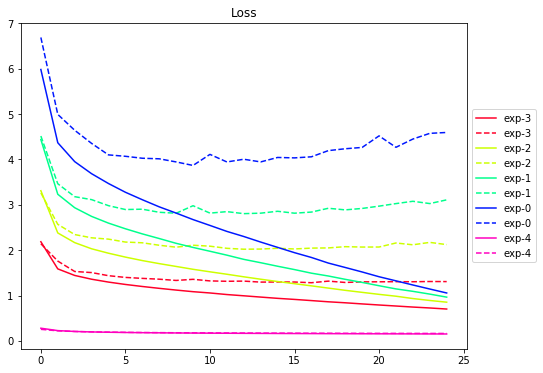

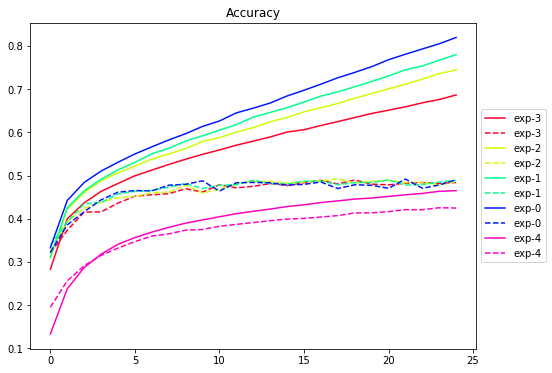

In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()